In [1]:
import json
import requests
import psycopg2
from time import gmtime, strftime

import pandas as pd
import pandas.io.sql as sqlio

import matplotlib.pyplot as plt


### Query Bicing API + Insert into DB Locally

In [22]:
r = requests.get('http://wservice.viabicing.cat/v2/stations')
bicingJson = r.json()

In [26]:
#conexión a la base de datos
try:
    conn = psycopg2.connect("dbname='bicing' user='postgres' host='localhost' password='root'")
except:
    print("I am unable to connect to the database")

In [27]:
cursor = conn.cursor()
cursor.executemany("INSERT into bicing(id_station,lat,lon,slots,bikes) VALUES (%(id)s, %(latitude)s,%(longitude)s,%(slots)s,%(bikes)s)",bicingJson['stations'])
conn.commit()
cursor.close()

In [28]:
conn.close()

### External query of the DB

In [19]:
try:
    conn = psycopg2.connect("dbname='bicing' user='postgres' host='192.168.1.205' password='root'")
except:
    print("I am unable to connect to the database")
sql = "SELECT distinct(hora) FROM bicing ORDER BY hora DESC LIMIT 3000;"
#sql = "SELECT * FROM bicing WHERE bikesdifference != 0 LIMIT 3000"
df = sqlio.read_sql_query(sql, conn)
conn.close()

In [20]:
df.head()

,hora
0,2018-10-25 07:03:02.614919
1,2018-10-25 07:02:02.340973
2,2018-10-25 07:01:03.151691
3,2018-10-25 07:00:03.035030
4,2018-10-25 06:59:02.937922


In [3]:
df = df.assign(total_space = df.slots+df.bikes)
df.head()

,id,id_station,lat,lon,slots,bikes,hora,hmin,bikesdifference,total_space
0,1094637,108,41.4023,2.16496,7,14,2018-10-24 14:16:03.152525,02:17,14,21
1,1164968,62,41.3871,2.16886,1,20,2018-10-24 16:48:02.560238,04:49,7,21
2,1094638,109,41.3910,2.14737,13,7,2018-10-24 14:16:03.152525,02:17,7,20
3,1316514,208,41.3915,2.13912,11,22,2018-10-24 22:15:02.767724,10:16,17,33
4,1094639,110,41.3854,2.15488,15,5,2018-10-24 14:16:03.152525,02:17,3,20


In [8]:
print(df.groupby('id_station')['total_space'].value_counts().sort_values(ascending=False).head(10))

df['total_space'][df['id_station']==9]

id_station  total_space
282         27             10
240         27             10
285         24             10
278         24             10
271         20              9
294         27              9
292         26              9
289         27              9
275         33              9
274         33              9
Name: total_space, dtype: int64


965     25
1378    26
1477    25
2209    25
2713    27
Name: total_space, dtype: int64

In [51]:
df.iloc[[1147,1516]]

,id,id_station,lat,lon,slots,bikes,hora,hmin,bikesdifference,total_space
1147,381984,9,41.3845,2.18492,18,9,2018-10-23 12:32:02.923265,12:33,-1,27
1516,385225,9,41.3845,2.18492,18,8,2018-10-23 12:39:02.931840,12:40,-1,26


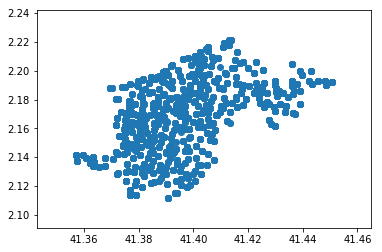

In [12]:
plt.scatter(df.lat,df.lon)

### Batch file downloaded from Open data BCN

In [33]:
df_batch = pd.read_csv("2018_09_setembre_bicing_estacions.csv", sep=";")
df_batch = df_batch.assign(total_space = df_batch.slots+df_batch.bikes)
df_batch.head()

,id,type,latitude,longitude,streetName,streetNumber,altitude,slots,bikes,nearbyStations,status,updateTime,total_space
0,1,BIKE,"41,397952","2,180042",Gran Via Corts Catalanes,760,21,24,5,"24, 369, 387, 426",OPN,01/09/18 00:00:22,29
1,2,BIKE,"41,39553","2,17706",Roger de Flor/ Gran Vía,126,21,12,12,"360, 368, 387, 414",OPN,01/09/18 00:00:22,24
2,3,BIKE,"41,394072","2,183441",Nàpols,82,22,15,9,"4, 6, 119, 419",OPN,01/09/18 00:00:22,24
3,4,BIKE,"41,39347","2,18149",Ribes,13,21,4,14,"3, 5, 359, 419",OPN,01/09/18 00:00:22,18
4,5,BIKE,"41,391075","2,180223",Pg Lluís Companys,11,16,27,12,"6, 7, 359, 418",OPN,01/09/18 00:00:22,39


In [34]:
df_batch.groupby('id')['total_space'].value_counts().sort_values(ascending=False).head(10)

id   total_space
357  27             2367
479  12             2367
456  12             2367
480  12             2367
257  27             2367
464  12             2367
481  12             2366
484  12             2366
466  12             2366
482  12             2365
Name: total_space, dtype: int64